In [1]:
import numpy as np
import pandas as pd
import lib.recommenders as rec
import networkx as nx
import matplotlib.pyplot as plt
import lib.areamanager
import math
import timeit
import lib.geo_utils
from collections import defaultdict
from lib.constants import experiment_constants
import lib.geocat.cat_utils as cat_utils
def string_to_array(string):
    if string == '':
        return list()
    return eval(string)
%matplotlib inline

from lib.usg.UserBasedCF import UserBasedCF
from lib.usg.FriendBasedCF import FriendBasedCF
from lib.usg.PowerLaw import PowerLaw

from lib.metrics import precisionk, recallk, ildk,gck,prk
import pickle
# poi_int_id=df_checkin_train['business_id'].drop_duplicates().reset_index(drop=True).to_dict()
# poi_num=len(poi_int_to_id)
# user_int_id=df_checkin_train.reset_index().user_id.drop_duplicates().reset_index(drop=True).to_dict()
# user_num=len(user_int_to_id)
# for i,j in poi_int_id.copy().items():
#     poi_int_id[j]=i
# for i,j in user_int_id.copy().items():
#     user_int_id[j]=i
# def user_id_to_int(user_id):
#     return user_int_id[user_id]
# def poi_id_to_int(user_id):
#     return poi_int_id[user_id]

CITY=experiment_constants.CITY

In [2]:
#Train load
data_checkin_train = pickle.load(open("../data/checkin/train/"+CITY+".pickle","rb"))

#Test load
ground_truth = defaultdict(set)
for checkin in pickle.load(open("../data/checkin/test/"+CITY+".pickle","rb")):
    ground_truth[checkin['user_id']].add(checkin['poi_id'])
#Pois load
poi_coos = {}
poi_cats = {}
for poi_id,poi in pickle.load(open("../data/poi/"+CITY+".pickle","rb")).items():
    poi_coos[poi_id] = tuple([poi['latitude'],poi['longitude']])
    poi_cats[poi_id] = poi['categories']
    
#Social relations load
social_relations = defaultdict(list)
for user_id,friends in pickle.load(open("../data/user/"+CITY+".pickle","rb")).items():
    social_relations[user_id]=friends

user_num = len(social_relations)
poi_num = len(poi_coos)
user_num,poi_num

# Cat Hierarchy load
dict_alias_title,category_tree,dict_alias_depth=cat_utils.cat_structs()
undirected_category_tree=category_tree.to_undirected()

# Training matrix create
training_matrix = np.zeros((user_num, poi_num))
for checkin in data_checkin_train:
    training_matrix[checkin['user_id'],checkin['poi_id']]=1

# poi neighbors load
poi_neighbors=pickle.load(open("../data/neighbor/"+CITY+".pickle","rb"))

In [3]:
# Test if has error in training matrix, user with no checkin
for i in range(user_num):
    if (np.count_nonzero(training_matrix[i,:])) == 0:
        print("ZERO")

In [4]:
top_k = 100
alpha = 0.1
beta = 0.1

U = UserBasedCF()
S = FriendBasedCF(eta=0.05)
G = PowerLaw()

U.pre_compute_rec_scores(training_matrix)
S.compute_friend_sim(social_relations, training_matrix)
G.fit_distance_distribution(training_matrix, poi_coos)

Training User-based Collaborative Filtering...
Done. Elapsed time: 0.8846354484558105 s
Precomputing similarity between friends...
Done. Elapsed time: 0.4831266403198242 s
fitting distance distribution...
done. elapsed time: 2.562293529510498 s


In [5]:
result_out = open("../data/result/reclist/sigir11_top_" + str(top_k) + ".txt", 'w')

all_uids = list(range(user_num))
all_lids = list(range(poi_num))

In [6]:
# np.random.shuffle(all_uids)

In [7]:
precision, recall, ild, gc, pr = [], [], [], [], []

In [8]:
def normalize(scores):
    max_score = max(scores)
    if not max_score == 0:
        scores = [s / max_score for s in scores]
    return scores


In [9]:
for cnt, uid in enumerate(all_uids):
    if uid in ground_truth:
        U_scores = normalize([U.predict(uid, lid)
                              if training_matrix[uid, lid] == 0 else -1
                              for lid in all_lids])
        S_scores = normalize([S.predict(uid, lid)
                              if training_matrix[uid, lid] == 0 else -1
                              for lid in all_lids])
        G_scores = normalize([G.predict(uid, lid)
                              if training_matrix[uid, lid] == 0 else -1
                              for lid in all_lids])
        
        U_scores = np.array(U_scores)
        S_scores = np.array(S_scores)
        G_scores = np.array(G_scores)
        
        overall_scores = (1.0 - alpha - beta) * U_scores + alpha * S_scores + beta * G_scores
        
        predicted = list(reversed(overall_scores.argsort()))[:top_k]
        actual = ground_truth[uid]
        
        precision.append(precisionk(actual, predicted[:10]))
        recall.append(recallk(actual, predicted[:10]))
        pr.append(prk(training_matrix[uid],predicted[:10],poi_neighbors))
        ild.append(ildk(predicted[:10],poi_cats,undirected_category_tree))
        gc.append(gck(uid,training_matrix,poi_cats,predicted[:10]))
        print(cnt, uid, "pre@10:", np.mean(precision), "rec@10:", np.mean(recall),"ild@10:",np.mean(ild),"gc@10:",np.mean(gc),"pr@10:",np.mean(pr))
        
        result_out.write(str(uid)+',"'+str(predicted)+'"\n')
        
result_out.close()

0 0 pre@10: 0.1 rec@10: 0.08333333333333333 ild@10: 0.2222222222222222 gc@10: 0.35 pr@10: 0.029999999999999916
1 1 pre@10: 0.05 rec@10: 0.041666666666666664 ild@10: 0.2518518518518519 gc@10: 0.3592105263157894 pr@10: 0.11860655737704912
2 2 pre@10: 0.03333333333333333 rec@10: 0.027777777777777776 ild@10: 0.2765432098765433 gc@10: 0.3783625730994152 pr@10: 0.07907103825136608
3 3 pre@10: 0.025 rec@10: 0.020833333333333332 ild@10: 0.33333333333333337 gc@10: 0.3671052631578947 pr@10: 0.10336065573770489
4 4 pre@10: 0.06000000000000001 rec@10: 0.056666666666666664 ild@10: 0.31111111111111117 gc@10: 0.37603715170278634 pr@10: 0.12068852459016391
5 5 pre@10: 0.05000000000000001 rec@10: 0.04722222222222222 ild@10: 0.30864197530864207 gc@10: 0.4022531819745441 pr@10: 0.10057377049180326
6 6 pre@10: 0.042857142857142864 rec@10: 0.04047619047619048 ild@10: 0.30476190476190484 gc@10: 0.4356975326015573 pr@10: 0.08620608899297422
7 7 pre@10: 0.037500000000000006 rec@10: 0.035416666666666666 ild@10

59 59 pre@10: 0.06166666666666667 rec@10: 0.05002989478768663 ild@10: 0.30706172839506174 gc@10: 0.40398778692133347 pr@10: 0.11387094599126417
60 60 pre@10: 0.06229508196721312 rec@10: 0.05125891290592128 ild@10: 0.30639951426836676 gc@10: 0.4023543449404421 pr@10: 0.11415823128382065
61 61 pre@10: 0.06290322580645162 rec@10: 0.05144022076227738 ild@10: 0.30814814814814817 gc@10: 0.4014091135704349 pr@10: 0.11390836733838268
62 62 pre@10: 0.061904761904761914 rec@10: 0.050623709321606314 ild@10: 0.3100764256319812 gc@10: 0.40209221406049855 pr@10: 0.11504915163107149
63 63 pre@10: 0.060937500000000006 rec@10: 0.04983271386345622 ild@10: 0.3100925925925927 gc@10: 0.40166889821580326 pr@10: 0.11509272485305222
64 64 pre@10: 0.060000000000000005 rec@10: 0.04906605672709535 ild@10: 0.3101082621082622 gc@10: 0.4036341730848814 pr@10: 0.11428470491025801
65 65 pre@10: 0.0590909090909091 rec@10: 0.048322631625169664 ild@10: 0.30989898989899 gc@10: 0.40479123106844384 pr@10: 0.114227656055852

117 117 pre@10: 0.05 rec@10: 0.04296115544393096 ild@10: 0.3093785310734464 gc@10: 0.40339184527431815 pr@10: 0.11926799564806656
118 118 pre@10: 0.049579831932773114 rec@10: 0.04260013733095675 ild@10: 0.3090196078431373 gc@10: 0.404670531915337 pr@10: 0.1182657435837971
119 119 pre@10: 0.04916666666666667 rec@10: 0.04224513618653211 ild@10: 0.30841975308641983 gc@10: 0.40754827748270905 pr@10: 0.11786890539801816
120 120 pre@10: 0.0487603305785124 rec@10: 0.04189600282961862 ild@10: 0.30929905111723305 gc@10: 0.40714684013966485 pr@10: 0.11828517087656253
121 121 pre@10: 0.04918032786885246 rec@10: 0.04360177329822831 ild@10: 0.3108925318761386 gc@10: 0.4070882594827823 pr@10: 0.11949964990956795
122 122 pre@10: 0.04959349593495935 rec@10: 0.04415062970321109 ild@10: 0.3100511894007831 gc@10: 0.4078436394869873 pr@10: 0.12016026021096278
123 123 pre@10: 0.04919354838709677 rec@10: 0.04379457623786261 ild@10: 0.3105376344086023 gc@10: 0.40765631485092607 pr@10: 0.12009575942024665
124

174 174 pre@10: 0.04228571428571429 rec@10: 0.03907452057130971 ild@10: 0.30774179894179904 gc@10: 0.4056853985205215 pr@10: 0.12326912725676344
175 175 pre@10: 0.042045454545454546 rec@10: 0.03885250624988181 ild@10: 0.30742424242424254 gc@10: 0.4062212769380186 pr@10: 0.1225687344882591
176 176 pre@10: 0.04180790960451978 rec@10: 0.038633000564854234 ild@10: 0.30761247122829055 gc@10: 0.4059439977301363 pr@10: 0.12312788548854274
177 177 pre@10: 0.04157303370786517 rec@10: 0.038415961235838195 ild@10: 0.30704952143154396 gc@10: 0.40712063041358837 pr@10: 0.1227312688312022
178 178 pre@10: 0.04134078212290503 rec@10: 0.038201346927258094 ild@10: 0.3071549762052556 gc@10: 0.4063698295326592 pr@10: 0.12348548436318767
179 179 pre@10: 0.041666666666666664 rec@10: 0.03822059870358814 ild@10: 0.30635390946502067 gc@10: 0.4057638710202406 pr@10: 0.12345932599682144
180 180 pre@10: 0.04143646408839779 rec@10: 0.03800943517483903 ild@10: 0.3059709433190097 gc@10: 0.4058898796254958 pr@10: 0.1

231 231 pre@10: 0.04396551724137931 rec@10: 0.04221357094016438 ild@10: 0.3080970625798213 gc@10: 0.4157533407828179 pr@10: 0.12420274225604505
232 232 pre@10: 0.04377682403433476 rec@10: 0.04203239681595767 ild@10: 0.30798283261802584 gc@10: 0.41488867285793757 pr@10: 0.12417244231993695
233 233 pre@10: 0.045299145299145305 rec@10: 0.042053877271998066 ild@10: 0.30850269072491304 gc@10: 0.4141708305818221 pr@10: 0.12437794419229561
234 234 pre@10: 0.04595744680851064 rec@10: 0.042087690560202326 ild@10: 0.3095224586288417 gc@10: 0.4138552100261548 pr@10: 0.1244424955417421
235 235 pre@10: 0.0461864406779661 rec@10: 0.042615567577602605 ild@10: 0.3095919648462022 gc@10: 0.4141193425099019 pr@10: 0.12428638327249743
236 236 pre@10: 0.04683544303797469 rec@10: 0.0431389899366282 ild@10: 0.3097859040475075 gc@10: 0.41352275149816087 pr@10: 0.12437499497312757
237 237 pre@10: 0.047058823529411764 rec@10: 0.04379806981084404 ild@10: 0.3099159663865547 gc@10: 0.41388610128178205 pr@10: 0.124

288 288 pre@10: 0.05363321799307958 rec@10: 0.04448364229015527 ild@10: 0.3128437780340895 gc@10: 0.4114021388470209 pr@10: 0.12306997351308151
289 289 pre@10: 0.05344827586206896 rec@10: 0.04433025042018922 ild@10: 0.312837803320562 gc@10: 0.41090305101191626 pr@10: 0.12303942369515983
290 290 pre@10: 0.0536082474226804 rec@10: 0.044282046914631966 ild@10: 0.31323914980272377 gc@10: 0.41055466873876123 pr@10: 0.12273275368112972
291 291 pre@10: 0.05342465753424657 rec@10: 0.04413039606903391 ild@10: 0.3130796549974633 gc@10: 0.41007068278154213 pr@10: 0.12248685463618798
292 292 pre@10: 0.05324232081911262 rec@10: 0.043979780382791475 ild@10: 0.3129212488939452 gc@10: 0.41037760877887475 pr@10: 0.12258551843892183
293 293 pre@10: 0.05374149659863945 rec@10: 0.045190733510741175 ild@10: 0.3126127488032251 gc@10: 0.41052783954678823 pr@10: 0.12216856089321122
294 294 pre@10: 0.05389830508474576 rec@10: 0.04546127339714544 ild@10: 0.3124569993722537 gc@10: 0.4105635168079142 pr@10: 0.122

345 345 pre@10: 0.051156069364161845 rec@10: 0.04336956715797217 ild@10: 0.3117619353457505 gc@10: 0.4103567628449689 pr@10: 0.12240824812362443
346 346 pre@10: 0.05100864553314121 rec@10: 0.04324458281457744 ild@10: 0.3116746717899456 gc@10: 0.41037494700583843 pr@10: 0.12243623937433794
347 347 pre@10: 0.051149425287356325 rec@10: 0.043271556941395804 ild@10: 0.3121839080459771 gc@10: 0.41000620084217587 pr@10: 0.1223047176136837
348 348 pre@10: 0.0510028653295129 rec@10: 0.043147569672222746 ild@10: 0.31205348615090744 gc@10: 0.40967414194881385 pr@10: 0.1224624417103506
349 349 pre@10: 0.05085714285714286 rec@10: 0.04302429090173068 ild@10: 0.31145820105820116 gc@10: 0.4092179301146744 pr@10: 0.12238211423714089
350 350 pre@10: 0.05071225071225072 rec@10: 0.042901714574375326 ild@10: 0.3114994196475679 gc@10: 0.4093470683609159 pr@10: 0.12203344724501228
351 351 pre@10: 0.05056818181818181 rec@10: 0.0427798347034254 ild@10: 0.31128787878787884 gc@10: 0.40960460509852703 pr@10: 0.12

402 402 pre@10: 0.050124069478908184 rec@10: 0.043087867676855234 ild@10: 0.3112875654811139 gc@10: 0.40853440559470316 pr@10: 0.12188230663177346
403 403 pre@10: 0.050742574257425746 rec@10: 0.043181910284291435 ild@10: 0.31165383204987174 gc@10: 0.4080788496301578 pr@10: 0.12181482391570497
404 404 pre@10: 0.050617283950617285 rec@10: 0.04307528828358948 ild@10: 0.3116524919981711 gc@10: 0.40815149444588583 pr@10: 0.12176638020715068
405 405 pre@10: 0.05073891625615764 rec@10: 0.04310602785815098 ild@10: 0.3120160554643314 gc@10: 0.4076739925243091 pr@10: 0.12175093223987815
406 406 pre@10: 0.05085995085995085 rec@10: 0.043204866446542096 ild@10: 0.311941031941032 gc@10: 0.4074913373420216 pr@10: 0.12205234574667992
407 407 pre@10: 0.05098039215686274 rec@10: 0.04325215844054567 ild@10: 0.3121205519244736 gc@10: 0.4072278781818696 pr@10: 0.12198240490788041
408 408 pre@10: 0.0511002444987775 rec@10: 0.043418072750253646 ild@10: 0.3118283075251291 gc@10: 0.40678430501177437 pr@10: 0.1

459 459 pre@10: 0.0508695652173913 rec@10: 0.04303058582558974 ild@10: 0.31370048309178755 gc@10: 0.40665952400984756 pr@10: 0.12409006556451413
460 460 pre@10: 0.05075921908893709 rec@10: 0.04293724399082707 ild@10: 0.3132128223668354 gc@10: 0.4069454285965106 pr@10: 0.1240749956980897
461 461 pre@10: 0.050865800865800864 rec@10: 0.04311486900383394 ild@10: 0.31324033990700667 gc@10: 0.40676282084015736 pr@10: 0.12400449868650096
462 462 pre@10: 0.05075593952483801 rec@10: 0.04302174833643905 ild@10: 0.31288376929845624 gc@10: 0.40671498620468266 pr@10: 0.1241025705353549
463 463 pre@10: 0.05107758620689655 rec@10: 0.04316849265276377 ild@10: 0.3128799489144317 gc@10: 0.4066466349413105 pr@10: 0.12388093166765443
464 464 pre@10: 0.05096774193548387 rec@10: 0.043075657184693306 ild@10: 0.31278056551174843 gc@10: 0.4065248142210066 pr@10: 0.123724048443763
465 465 pre@10: 0.05085836909871244 rec@10: 0.04298322015210813 ild@10: 0.31274519154347485 gc@10: 0.40622468944084705 pr@10: 0.1239

516 516 pre@10: 0.05125725338491296 rec@10: 0.043994468186793305 ild@10: 0.31205673758865254 gc@10: 0.40627224536885986 pr@10: 0.12465901856918811
517 517 pre@10: 0.05115830115830116 rec@10: 0.0439095367810273 ild@10: 0.31205491205491204 gc@10: 0.40631529398508104 pr@10: 0.12465919763189169
518 518 pre@10: 0.051059730250481696 rec@10: 0.04382493266391549 ild@10: 0.3118247341754086 gc@10: 0.40625495623173796 pr@10: 0.12489839651661525
519 519 pre@10: 0.05115384615384615 rec@10: 0.043915479122079285 ild@10: 0.3116239316239317 gc@10: 0.40611472234154866 pr@10: 0.12482964755441062
520 520 pre@10: 0.0510556621880998 rec@10: 0.043831188375203896 ild@10: 0.3115660766332552 gc@10: 0.40609405845453866 pr@10: 0.12474183721317397
521 521 pre@10: 0.050957854406130265 rec@10: 0.04374722058138167 ild@10: 0.31153682418050244 gc@10: 0.406848667537959 pr@10: 0.12462273681347716
522 522 pre@10: 0.051051625239005735 rec@10: 0.043902579624247096 ild@10: 0.3115076835918137 gc@10: 0.4068355725713473 pr@10: 

573 573 pre@10: 0.05017421602787457 rec@10: 0.04383245978456367 ild@10: 0.31144663827590663 gc@10: 0.4070276076970975 pr@10: 0.12569691814407283
574 574 pre@10: 0.05008695652173914 rec@10: 0.043756229419720946 ild@10: 0.3114718196457328 gc@10: 0.40691755968371124 pr@10: 0.12584636482237868
575 575 pre@10: 0.049999999999999996 rec@10: 0.04368026374364505 ild@10: 0.311522633744856 gc@10: 0.4070280990510905 pr@10: 0.12576067882107278
576 576 pre@10: 0.049913344887348346 rec@10: 0.043604561380137866 ild@10: 0.3113678670004493 gc@10: 0.4069003784865883 pr@10: 0.12572435573799812
577 577 pre@10: 0.049826989619377156 rec@10: 0.04352912096252517 ild@10: 0.31134179161860825 gc@10: 0.4069749453058156 pr@10: 0.12568226403055732
578 578 pre@10: 0.049740932642487044 rec@10: 0.04345394113357435 ild@10: 0.31154608840273784 gc@10: 0.40725897574816927 pr@10: 0.1258806909123205
579 579 pre@10: 0.05 rec@10: 0.043644272534802936 ild@10: 0.31151979565772675 gc@10: 0.40717749475549997 pr@10: 0.1259018997524

630 630 pre@10: 0.04960380348652931 rec@10: 0.04313137351014947 ild@10: 0.312280331044198 gc@10: 0.4090653634200585 pr@10: 0.12550307141790606
631 631 pre@10: 0.049525316455696196 rec@10: 0.04306312766598784 ild@10: 0.3121378340365683 gc@10: 0.4093222672301986 pr@10: 0.12544309820363722
632 632 pre@10: 0.04976303317535545 rec@10: 0.04306857553366713 ild@10: 0.31218302030308354 gc@10: 0.40913639740308394 pr@10: 0.12549907018506185
633 633 pre@10: 0.049842271293375394 rec@10: 0.04312197380084285 ild@10: 0.31250847061572623 gc@10: 0.4091336702895261 pr@10: 0.12552849583079118
634 634 pre@10: 0.04976377952755905 rec@10: 0.04305406518068405 ild@10: 0.31243627879848357 gc@10: 0.4090142996801463 pr@10: 0.12548076180791487
635 635 pre@10: 0.049999999999999996 rec@10: 0.04351047912432029 ild@10: 0.31222455159562085 gc@10: 0.4090858895462867 pr@10: 0.12549120276752698
636 636 pre@10: 0.05023547880690738 rec@10: 0.04350141377099577 ild@10: 0.31228327228327235 gc@10: 0.40877315901828604 pr@10: 0.1

687 687 pre@10: 0.04985465116279069 rec@10: 0.043425736489651805 ild@10: 0.31142118863049106 gc@10: 0.4096297136091307 pr@10: 0.12510437460388565
688 688 pre@10: 0.049782293178519586 rec@10: 0.04336270929590775 ild@10: 0.31174326721496537 gc@10: 0.4094073341356926 pr@10: 0.12515153806599902
689 689 pre@10: 0.049710144927536226 rec@10: 0.0432998647896818 ild@10: 0.31178529253891574 gc@10: 0.40918972823007455 pr@10: 0.12520027567431624
690 690 pre@10: 0.04978292329956586 rec@10: 0.043478398511645595 ild@10: 0.3117414375301496 gc@10: 0.4088387541901853 pr@10: 0.1251658257078371
691 691 pre@10: 0.04971098265895955 rec@10: 0.043415568455992926 ild@10: 0.31184757011346614 gc@10: 0.4090085186920402 pr@10: 0.12527094297812083
692 692 pre@10: 0.04963924963924965 rec@10: 0.0433529197280622 ild@10: 0.31193201859868536 gc@10: 0.40895944435049325 pr@10: 0.12523764453508054
693 693 pre@10: 0.04985590778097982 rec@10: 0.043377780161603985 ild@10: 0.3119948767211016 gc@10: 0.40893895068731556 pr@10: 0

744 744 pre@10: 0.05046979865771812 rec@10: 0.04427661588195247 ild@10: 0.3124514044245589 gc@10: 0.4105248635157486 pr@10: 0.12569503180803693
745 745 pre@10: 0.05040214477211796 rec@10: 0.044217263849939126 ild@10: 0.31225101777380604 gc@10: 0.4104772430552717 pr@10: 0.1258074583302665
746 746 pre@10: 0.05033467202141901 rec@10: 0.04415807072564202 ild@10: 0.3121304972978334 gc@10: 0.4108202007843365 pr@10: 0.1256988725460908
747 747 pre@10: 0.050534759358288765 rec@10: 0.04436641555087512 ild@10: 0.31222816399286996 gc@10: 0.4106397754744183 pr@10: 0.1256330869251337
748 748 pre@10: 0.050600801068090784 rec@10: 0.04436786832778256 ild@10: 0.3122266726005044 gc@10: 0.41053656260106575 pr@10: 0.1257149345219452
749 749 pre@10: 0.05053333333333333 rec@10: 0.044308711170012186 ild@10: 0.31230419753086425 gc@10: 0.4106045651329822 pr@10: 0.12582406257672893
750 750 pre@10: 0.05046604527296937 rec@10: 0.04424971155460604 ild@10: 0.3122237017310254 gc@10: 0.4103431552117475 pr@10: 0.125843

801 801 pre@10: 0.049251870324189526 rec@10: 0.043537876694440286 ild@10: 0.31102613835780923 gc@10: 0.41094315405824877 pr@10: 0.12503239293924817
802 802 pre@10: 0.04919053549190536 rec@10: 0.04348365766991421 ild@10: 0.3109155481758222 gc@10: 0.4110955702217295 pr@10: 0.1250412208585283
803 803 pre@10: 0.049129353233830844 rec@10: 0.043429573518583474 ild@10: 0.3108605122535471 gc@10: 0.4112061478707075 pr@10: 0.12488569695198785
804 804 pre@10: 0.04919254658385094 rec@10: 0.04344463685030641 ild@10: 0.3109528410397976 gc@10: 0.4112014289384549 pr@10: 0.12501449910306792
805 805 pre@10: 0.049131513647642684 rec@10: 0.04339073531575268 ild@10: 0.3108059920963147 gc@10: 0.41134425072571956 pr@10: 0.12508225981091725
806 806 pre@10: 0.04907063197026022 rec@10: 0.043336967366166865 ild@10: 0.31075129652576994 gc@10: 0.4113508460366748 pr@10: 0.12511054322719145
807 807 pre@10: 0.049133663366336636 rec@10: 0.04346013590019036 ild@10: 0.31086175284195094 gc@10: 0.4112685152695587 pr@10: 0

858 858 pre@10: 0.04970896391152503 rec@10: 0.04435152034836463 ild@10: 0.311480187987755 gc@10: 0.41236372678325806 pr@10: 0.12479601620669914
859 859 pre@10: 0.049883720930232564 rec@10: 0.044410690784282905 ild@10: 0.31165202411714044 gc@10: 0.41237753922216397 pr@10: 0.12472412583556308
860 860 pre@10: 0.04982578397212544 rec@10: 0.044359110423325555 ild@10: 0.3115653632726804 gc@10: 0.41247930746929273 pr@10: 0.1247219261408403
861 861 pre@10: 0.04976798143851509 rec@10: 0.0443076497383797 ild@10: 0.311599209418235 gc@10: 0.41261950935544595 pr@10: 0.12484621678930369
862 862 pre@10: 0.05017381228273465 rec@10: 0.044545995451313214 ild@10: 0.3114784773185701 gc@10: 0.4124448688601381 pr@10: 0.12482035804503094
863 863 pre@10: 0.05011574074074074 rec@10: 0.044494437586207525 ild@10: 0.3115294924554185 gc@10: 0.41227208301045837 pr@10: 0.12477110317570034
864 864 pre@10: 0.05005780346820809 rec@10: 0.0444429989300385 ild@10: 0.3114776279169344 gc@10: 0.4124260511751336 pr@10: 0.1248

915 915 pre@10: 0.05010917030567686 rec@10: 0.04503630931419938 ild@10: 0.3114539867378296 gc@10: 0.4132624666722746 pr@10: 0.12425105103240047
916 916 pre@10: 0.05005452562704472 rec@10: 0.04498719665409665 ild@10: 0.31142130134496554 gc@10: 0.4131147189199359 pr@10: 0.12433426527406449
917 917 pre@10: 0.05 rec@10: 0.04493819099325341 ild@10: 0.31143710158960713 gc@10: 0.41328717409696064 pr@10: 0.12419882489794895
918 918 pre@10: 0.049945593035908606 rec@10: 0.04488929198237936 ild@10: 0.3113722645387499 gc@10: 0.4134419819113878 pr@10: 0.12422727539053684
919 919 pre@10: 0.04989130434782609 rec@10: 0.04484049927370286 ild@10: 0.3113880837359099 gc@10: 0.41335490729336816 pr@10: 0.1242665728655264
920 920 pre@10: 0.049837133550488605 rec@10: 0.04479181252096268 ild@10: 0.31135561185506905 gc@10: 0.41323182921813106 pr@10: 0.1242960286483404
921 921 pre@10: 0.049891540130151846 rec@10: 0.04485169124924797 ild@10: 0.311258937896682 gc@10: 0.41326568237998174 pr@10: 0.1242539615934958
9

972 972 pre@10: 0.04892086330935252 rec@10: 0.044229694163718164 ild@10: 0.31193331049446166 gc@10: 0.41400459986136634 pr@10: 0.12364718421712599
973 973 pre@10: 0.04897330595482546 rec@10: 0.044277619622388985 ild@10: 0.3118868355007986 gc@10: 0.41398288789318954 pr@10: 0.12355968305533385
974 974 pre@10: 0.04892307692307692 rec@10: 0.04423220667918653 ild@10: 0.31185565052231723 gc@10: 0.41407111057227347 pr@10: 0.12350834878751281
975 975 pre@10: 0.04897540983606557 rec@10: 0.044357651822616334 ild@10: 0.31170309653916217 gc@10: 0.41387971878610585 pr@10: 0.12355681442483177
976 976 pre@10: 0.04892528147389969 rec@10: 0.04431224992719912 ild@10: 0.3115811820008341 gc@10: 0.41387755398272436 pr@10: 0.12350265715447915
977 977 pre@10: 0.04887525562372188 rec@10: 0.0442669408781938 ild@10: 0.3116261455729759 gc@10: 0.41396561374347823 pr@10: 0.12348659780173377
978 978 pre@10: 0.048825331971399384 rec@10: 0.044221724391086355 ild@10: 0.31167101728899493 gc@10: 0.4138393185104871 pr@10

In [10]:
df_metrics=pd.DataFrame([ild,gc,pr])

In [11]:
df_metrics=pd.DataFrame([ild,gc,pr]).T
df_metrics.columns=['ild','gc','pr']

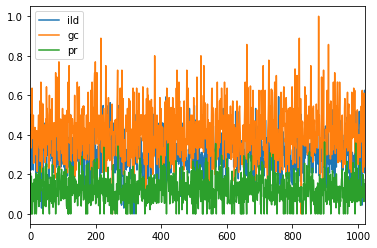

In [12]:
df_metrics.plot()

In [13]:
df_metrics.corr()

,ild,gc,pr
ild,1.000000,-0.050520,0.078475
gc,-0.050520,1.000000,-0.030126
pr,0.078475,-0.030126,1.000000


In [18]:
corr = df_metrics.corr()

In [29]:
import seaborn as sns

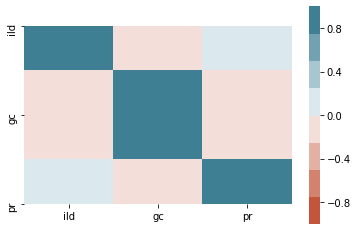

In [56]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,vmin=-1, vmax=1,center=0,
           cmap=sns.diverging_palette(20, 220, n=8),square=True
           )

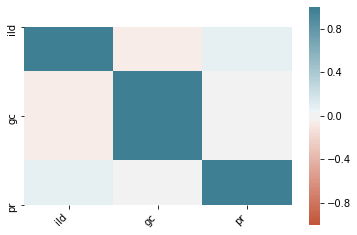

In [31]:
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
# import itertools
# for m1,m2 in itertools.combinations(df_metrics.columns,2):
#     df_metrics=df_metrics.sort_values(m1)
#     df_metrics=df_metrics.reset_index(drop=True)
#     df_metrics[[m1,m2]].plot()
#     df_metrics=df_metrics.sort_values(m2)
#     df_metrics=df_metrics.reset_index(drop=True)
#     df_metrics[[m1,m2]].plot()